<a href="https://colab.research.google.com/github/benmsanderson/energybalance/blob/main/4xCO2_unifyensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

authdrive=1

Install some stuff

In [ ]:
!pip install --upgrade xarray zarr gcsfs cftime pydsm nc-time-axis imgaug matplotlib==3.1.3 progress eofs netcdf4 >/dev/null
!pip install lmfit corner emcee >/dev/null


ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.


Import stuff

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from netCDF4 import num2date
import numpy as np
import pydsm.relab as relab
import numpy.matlib
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import pickle
import cftime
import dask as da
from eofs.xarray import Eof
from sys import getsizeof
from IPython.display import HTML, display
import time
import scipy
import lmfit
import seaborn as sns
import emcee
import corner
from scipy import linalg
#from mpl_toolkits.basemap import Basemap


xr.set_options(display_style='html')



In [ ]:
lon_out=np.arange(1,359,2)
lat_out=np.arange(-89,89,2)
lons_sub, lats_sub = np.meshgrid(lon_out,lat_out)

Activate Google Drive to store arrays

In [ ]:
if authdrive:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Open xarray datasets

In [ ]:
#CMIP6
ds_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/abrupt-4xCO2.nc")
ds_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/piControl.nc")

#longrunmip
dslr_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/lrmip2_4x.nc")
dslr_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/lrmip2_cnt.nc")
#dslr_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/longrun/abrupt4x.nc")
#dslr_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/longrun/control.nc")


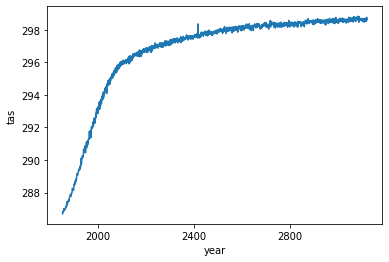

In [ ]:
dslr_4x['tas'][4,:].plot()

In [ ]:

#CMIP5
ds5_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/cmip5/abrupt-4xCO2.nc")
ds5_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/cmip5/piControl.nc")


Define model names

In [ ]:
mdls=pickle.load( open( "/content/drive/MyDrive/colab_4xco2/mdls.pkl", "rb" ))
mdls5=pickle.load( open( "/content/drive/MyDrive/colab_4xco2/mdls_cmip5.pkl", "rb" ))
mdlslr=pickle.load( open( "/content/drive/MyDrive/colab_4xco2/mdls_lrmip.pkl", "rb" ))

nm=len(mdls)
nm5=len(mdls5)
nmlr=len(mdlslr)


In [ ]:
lat=ds_4x.tas.lat
weights = np.cos(np.deg2rad(lat))
weights.name = "weights"  


In [ ]:
##ctrlmap=ds_cnt.tas.mean(dim='year')
#ctrlbc=xr.broadcast(ctrlmap,ds_4x.tas)
#map4x=ds_4x.tas-ctrlbc[0]

CMIP6 vectors

In [ ]:
gm4x_cmip6=ds_4x.weighted(weights).mean(dim='lat').mean(dim='lon')
gmcnt_cmip6=ds_cnt.weighted(weights).mean(dim='lat').mean(dim='lon')


In [ ]:
gm4x_cmip5=ds5_4x.weighted(weights).mean(dim='lat').mean(dim='lon')
gmcnt_cmip5=ds5_cnt.weighted(weights).mean(dim='lat').mean(dim='lon')

In [ ]:
dslr_4x

<xarray.Dataset>
Dimensions:  (year: 6000, ens: 16)
Coordinates:
  * year     (year) object 1850-12-31 00:00:00 ... 7849-12-31 00:00:00
Dimensions without coordinates: ens
Data variables:
    tas      (ens, year) float32 286.2 286.9 287.2 287.5 ... nan nan nan nan
    rlut     (ens, year) float32 227.1 228.6 228.7 229.4 ... nan nan nan nan
    rsut     (ens, year) float32 107.2 107.8 107.9 108.1 ... nan nan nan nan
    rsdt     (ens, year) float32 341.4 341.4 341.4 341.4 ... nan nan nan nan

In [ ]:
gm4x_cmip5['year']=xr.cftime_range(start="1850", periods=300, freq="Y", calendar="noleap")

In [ ]:
gm4x_cmip6['year']=xr.cftime_range(start="1850", periods=400, freq="Y", calendar="noleap")

In [ ]:
gmcnt_cmip5['year']=xr.cftime_range(start="1850", periods=400, freq="Y", calendar="noleap")

In [ ]:
gmcnt_cmip6['year']=xr.cftime_range(start="1850", periods=400, freq="Y", calendar="noleap")

In [ ]:
dsall_4x=xr.concat([dslr_4x,gm4x_cmip5,gm4x_cmip6],dim="ens",coords="minimal")
dsall_cnt=xr.concat([dslr_cnt,gmcnt_cmip5,gmcnt_cmip6],dim="ens",coords="minimal")




In [ ]:
dsall_cnt

<xarray.Dataset>
Dimensions:  (year: 6000, ens: 75)
Coordinates:
    height   float64 2.0
  * year     (year) object 1850-12-31 00:00:00 ... 7849-12-31 00:00:00
Dimensions without coordinates: ens
Data variables:
    tas      (ens, year) float64 285.1 285.1 284.9 285.0 ... nan nan nan nan
    rlut     (ens, year) float64 233.2 233.3 232.9 233.2 ... nan nan nan nan
    rsut     (ens, year) float64 108.3 109.1 108.4 108.8 ... nan nan nan nan
    rsdt     (ens, year) float64 341.4 341.4 341.4 341.4 ... nan nan nan nan

In [ ]:
mdlslr.tolist()+mdls5

['CCSM3II',
 'CCSM3',
 'CESM104',
 'CNRMCM61',
 'ECEARTH',
 'ECHAM5MPIOM',
 'FAMOUS',
 'GFDLCM3',
 'GFDLESM2M',
 'GISSE2R',
 'HadCM3L',
 'HadGEM2',
 'IPSLCM5A',
 'MIROC32',
 'MPIESM11',
 'MPIESM12',
 'ACCESS1-0',
 'ACCESS1-3',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'CanESM2',
 'FGOALS-g2',
 'FGOALS-s2',
 'GFDL-CM3',
 'GFDL-ESM2G',
 'GFDL-ESM2M',
 'GISS-E2-H',
 'GISS-E2-R',
 'HadGEM2-ES',
 'IPSL-CM5A-LR',
 'IPSL-CM5A-MR',
 'IPSL-CM5B-LR',
 'MIROC-ESM',
 'MIROC5',
 'MPI-ESM-LR',
 'MPI-ESM-P',
 'NorESM1-M',
 'bcc-csm1-1',
 'bcc-csm1-1-m',
 'inmcm4']

In [ ]:
dsall_cnt['ens']=dsall_cnt.ens.assign_attrs(model=mdlslr.tolist()+mdls5+mdls,family=['LongRunMIP']*nmlr+['CMIP5']*nm5+['CMIP6']*nm)

dsall_4x['ens']=dsall_4x.ens.assign_attrs(model=mdlslr.tolist()+mdls5+mdls,family=['LongRunMIP']*nmlr+['CMIP5']*nm5+['CMIP6']*nm)


In [ ]:
dsall_4x.ens.model


['CCSM3II',
 'CCSM3',
 'CESM104',
 'CNRMCM61',
 'ECEARTH',
 'ECHAM5MPIOM',
 'FAMOUS',
 'GFDLCM3',
 'GFDLESM2M',
 'GISSE2R',
 'HadCM3L',
 'HadGEM2',
 'IPSLCM5A',
 'MIROC32',
 'MPIESM11',
 'MPIESM12',
 'ACCESS1-0',
 'ACCESS1-3',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'CanESM2',
 'FGOALS-g2',
 'FGOALS-s2',
 'GFDL-CM3',
 'GFDL-ESM2G',
 'GFDL-ESM2M',
 'GISS-E2-H',
 'GISS-E2-R',
 'HadGEM2-ES',
 'IPSL-CM5A-LR',
 'IPSL-CM5A-MR',
 'IPSL-CM5B-LR',
 'MIROC-ESM',
 'MIROC5',
 'MPI-ESM-LR',
 'MPI-ESM-P',
 'NorESM1-M',
 'bcc-csm1-1',
 'bcc-csm1-1-m',
 'inmcm4',
 'ACCESS-CM2',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CIESM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'EC-Earth3',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',


In [ ]:
dsall_4x.to_netcdf('/content/drive/MyDrive/colab_4xco2/dsall_4x_v2.nc')
dsall_cnt.to_netcdf('/content/drive/MyDrive/colab_4xco2/dsall_cnt_v2.nc')


In [ ]:
dsall_cnt

<xarray.Dataset>
Dimensions:  (year: 6000, ens: 75)
Coordinates:
    height   float64 2.0
  * year     (year) object 1850-12-31 00:00:00 ... 7849-12-31 00:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 65 66 67 68 69 70 71 72 73 74
Data variables:
    tas      (ens, year) float64 285.1 285.1 284.9 285.0 ... nan nan nan nan
    rlut     (ens, year) float64 233.2 233.3 232.9 233.2 ... nan nan nan nan
    rsut     (ens, year) float64 108.3 109.1 108.4 108.8 ... nan nan nan nan
    rsdt     (ens, year) float64 341.4 341.4 341.4 341.4 ... nan nan nan nan

In [ ]:
dsall_4x

<xarray.Dataset>
Dimensions:  (year: 6000, ens: 75)
Coordinates:
    height   float64 2.0
  * year     (year) object 1850-12-31 00:00:00 ... 7849-12-31 00:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 65 66 67 68 69 70 71 72 73 74
Data variables:
    tas      (ens, year) float64 286.2 286.9 287.2 287.5 ... nan nan nan nan
    rlut     (ens, year) float64 227.1 228.6 228.7 229.4 ... nan nan nan nan
    rsut     (ens, year) float64 107.2 107.8 107.9 108.1 ... nan nan nan nan
    rsdt     (ens, year) float64 341.4 341.4 341.4 341.4 ... nan nan nan nan